- some source code:
1. PCA
2. (https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)
3. Correlation regarding to categorical data
4. (https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import prince
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [70]:
pd.__version__

'1.3.3'

In [71]:
df = pd.read_csv('C:/Users/Jake/PycharmProjects/DSML_Study/data/bank-full.csv')

In [72]:
df.shape

(45211, 2)

In [73]:
name_list = list(df.columns)[0].split(';')
target = list(df.columns)[0]

In [74]:
df[name_list] = df[target].str.split(pat=";", expand=True)

In [75]:
df = df.drop(columns = target)

In [76]:
'removing "" in the dataframe'
df = df.replace('"','', regex =True)
df.columns = df.columns.str.replace('"','')
df.head()

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 1. Knowing the data

In [77]:
def table(my_df):
    total = len(my_df)
    print('Data shape:' , my_df.shape)
    summary = pd.DataFrame(my_df.dtypes, columns = ['data_type'])
    summary['Missing data in %'] = my_df.isnull().sum().values/total *100
    summary['Unique'] = my_df.nunique().values
    summary['First Value'] = my_df.loc[0].values
    summary['Second Value'] = my_df.loc[1].values
    summary['Third Value'] = my_df.loc[2].values

    return summary

def intersection(lst_1, lst_2):
    lst_3 = [value for value in lst_1 if value in lst_2]
    return lst_3

t = table(df)
temp_df = df

Data shape: (45211, 18)


In [78]:
t

,data_type,Missing data in %,Unique,First Value,Second Value,Third Value
year,int64,0.0,3,2008,2008,2008
age,object,0.0,77,58,44,33
job,object,0.0,12,management,technician,entrepreneur
marital,object,0.0,3,married,single,married
education,object,0.0,4,tertiary,secondary,secondary
default,object,0.0,2,no,no,no
balance,object,0.0,7168,2143,29,2
housing,object,0.0,2,yes,yes,yes
loan,object,0.0,2,no,no,yes
contact,object,0.0,3,unknown,unknown,unknown


In [79]:
t.tail(10)
#t[t['Missing data in %'] >= 80]
#print(t[:25])
#print(type(t))

,data_type,Missing data in %,Unique,First Value,Second Value,Third Value
loan,object,0.0,2,no,no,yes
contact,object,0.0,3,unknown,unknown,unknown
day,object,0.0,31,5,5,5
month,object,0.0,12,may,may,may
duration,object,0.0,1573,261,151,76
campaign,object,0.0,48,1,1,1
pdays,object,0.0,559,-1,-1,-1
previous,object,0.0,41,0,0,0
poutcome,object,0.0,4,unknown,unknown,unknown
y,object,0.0,2,no,no,no


**Categorical Features - Transaction**

- Job
- Marital
- Education
- Default
- Housing
- Loan
- Contact
- Month (could convert to numerical)
- Poutcome
- y (the outcome that we need to predict)

First we pay attention to the distribution of the data.

# 2. Target Distribution


In [80]:
list1 = df['y'].values.tolist()
yes_count = 0
no_count = 0
for counter in list1:
    if counter == 'yes':
        yes_count +=1
    else:
        no_count +=1
yes_ratio = yes_count/len(list1)
no_ratio= no_count/len(list1)

7.548118737001324


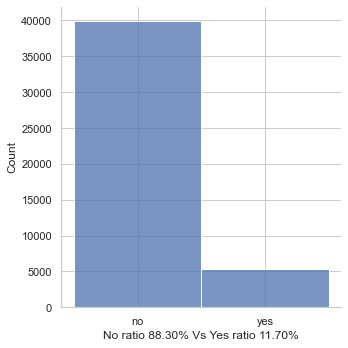

In [81]:
sns.set_theme(style = 'whitegrid')
ax = sns.displot(data = df['y'])
ax.set_xlabels('No ratio ' + '{:1.2f}%'.format(no_ratio*100) + ' Vs ' + 'Yes ratio '+'{:1.2f}%'.format(yes_ratio*100))
my_scale_pos_weight = no_count/yes_count
print(my_scale_pos_weight)

We have only 11.7% 'yes' in our dataset, hence the data is somehow imbalanced.

Now let's take a look at the distribution of some numerical feature.

In [82]:
numeric_list = ['balance','duration', 'pdays', 'previous', 'age', 'campaign', 'day']

df['balance'] = pd.to_numeric(df['balance'])
df['duration'] = pd.to_numeric(df['duration'])
df['pdays'] = pd.to_numeric(df['pdays'])
df['previous'] = pd.to_numeric(df['previous'])
df['age'] = pd.to_numeric(df['age'])
df['campaign'] = pd.to_numeric(df['campaign'])
df['day'] = pd.to_numeric((df['day']))

<AxesSubplot:ylabel='balance'>

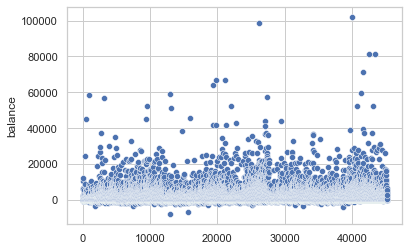

In [83]:
sns.scatterplot(data = df['balance'])

'pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)'

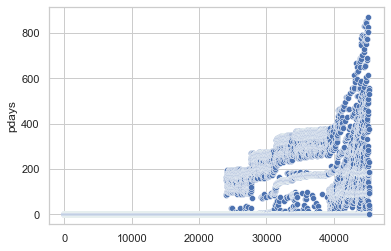

In [84]:
sns.scatterplot(data = df['pdays'])
'pdays: number of days that passed by after the client was last contacted from ' \
'a previous campaign (numeric, -1 means client was not previously contacted)'

In [85]:
def Calculate_outliers(df_num):
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    cut = data_std * 3
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]

    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points

    return outliers_total

In [86]:
out_balance = Calculate_outliers(df['balance'])

Identified lowest outliers: 1
Identified upper outliers: 744
Total outlier observations: 745
Non-outlier observations: 44466
Total percentual of Outliers:  1.6754


In [87]:
minimal = min(out_balance)
pos_out = out_balance.copy()
pos_out.remove(minimal)
min(pos_out) #get the positive minimal of the outliers

10500

In [88]:
'Here we list an example for one of outliers'
df.loc[df['balance'] == out_balance[3]]

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
446,2008,39,technician,single,unknown,no,45248,yes,no,unknown,6,may,1623,1,-1,0,unknown,yes


- In general, we will avoid the outliers and has more confidence in our distribution regarding to balance if
we set our balance value in the range(0, 10558)
- Notice that the ourliers only constitude 1.68% of the whole data and we have 40K rows in total.

In [89]:
out_pdays = Calculate_outliers(df['pdays'])

Identified lowest outliers: 0
Identified upper outliers: 1723
Total outlier observations: 1723
Non-outlier observations: 43488
Total percentual of Outliers:  3.962


In [90]:
min(out_pdays)

341

In [91]:
'Here list some outliers as previous'
df.loc[df['pdays'] == out_pdays[0]].head(3)

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32111,2009,32,services,married,secondary,no,1129,yes,no,cellular,15,apr,903,2,341,2,failure,yes
33073,2009,36,blue-collar,married,secondary,no,1589,yes,no,cellular,20,apr,345,2,341,6,other,no
33074,2009,32,admin.,married,secondary,no,413,yes,no,cellular,20,apr,95,3,341,2,failure,no


Now we try to deal with categorical data
- For day and month, since the column for year is missing, we can not transfer the day and month comlumn to datetime data type
- Hence, we regard the day as numeric data and month as categorical data and group by season for further investigation.

- First we try xgboost, note xgboost has support for categorical data using gpu_hist and gpu_predictor.


# 3. Feature Engineering

- First encode the categorical data and drop the outliers for pdays, it is reasonable since

In [92]:
one_hot_columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'month']

In [93]:
one_hot_df = df[one_hot_columns]
one_hot_df = pd.get_dummies(one_hot_df, columns=one_hot_columns)
df_drop = df.drop(one_hot_columns, axis = 1)
df_one_hot = pd.concat([df_drop, one_hot_df], axis=1)

- We change the binary categorical data to numerical data

In [94]:
binary_list = ['default', 'housing', 'loan', 'y']
df_one_hot[binary_list] = df_one_hot[binary_list].replace(to_replace='yes', value=1)
df_one_hot[binary_list] = df_one_hot[binary_list].replace(to_replace='no', value=0)
df_one_hot.shape

(45211, 50)

In [95]:
df_one_hot.head(1)

,year,age,default,balance,housing,loan,day,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,2008,58,0,2143,1,0,5,261,1,-1,...,0,0,0,0,0,0,1,0,0,0


# 4. Modelling and Prediction

In [96]:
model_xgb = XGBClassifier(eval_metric='mlogloss',
                          gamma = 6.55,
                          max_depth = 10,
                          scale_pos_weight = my_scale_pos_weight,
                          use_label_encoder = False)

model_svm_ovr = svm.SVC(decision_function_shape='ovr',
                        kernel='rbf',
                        gamma='auto',
                        class_weight='balanced')

In [97]:
def predic(input_data, target_data):
    kf = KFold(n_splits = 5, shuffle=True)
    fold_data = []
    for train_index, test_index in kf.split(input_data, target_data):
        #print("TRAIN size: {0:5d} from: {1:5d} to: {2:5d}".format(train_index.size, train_index[0], train_index[train_index.size - 1]))
        #print("TEST  size: {0:5d} from: {1:5d} to: {2:5d}".format(test_index.size, test_index[0], test_index[test_index.size - 1]))
        X_train, X_test = input_data.iloc[train_index], input_data.iloc[test_index]
        y_train, y_test = target_data.iloc[train_index], target_data.iloc[test_index]
        scaler_X_train = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler_X_train.transform(X_train)

        scaler_X_test = preprocessing.StandardScaler().fit(X_test)
        X_test_scaled = scaler_X_test.transform(X_test)

        model_xgb.fit(X_train, y_train)
        model_svm_ovr.fit(X_train_scaled, y_train)
        y_pred_xgb = model_xgb.predict(X_test)
        y_pred_svm = model_svm_ovr.predict(X_test_scaled)

        importance = model_xgb.feature_importances_
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()

        result = cross_val_score(model_xgb , X, y, cv = kf)

        print('mcc for XGB_classifier ', matthews_corrcoef(y_test, y_pred_xgb))
        print('mcc for SVM_classifier ', matthews_corrcoef(y_test, y_pred_svm))
        print("Avg accuracy: {}".format(result.mean()))
        print(' ')

In [98]:
y = df_one_hot['y']
input_list = list(df_one_hot.columns)
input_list.remove('y')
X = df_one_hot[input_list]

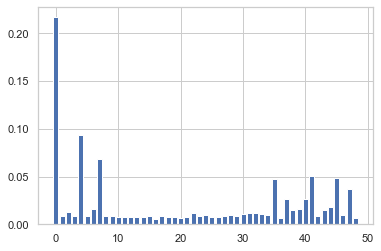

mcc for XGB_classifier  0.5848229142839495
mcc for SVM_classifier  0.5623877687143596
Avg accuracy: 0.8872618676092106
 


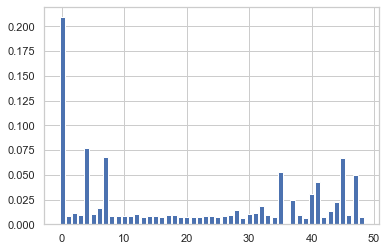

mcc for XGB_classifier  0.5956474402422883
mcc for SVM_classifier  0.5680634630362074
Avg accuracy: 0.8869964689583203
 


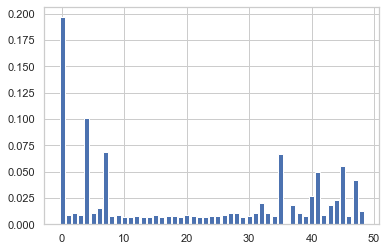

mcc for XGB_classifier  0.5955034528841179
mcc for SVM_classifier  0.5657087795733102
Avg accuracy: 0.8859127064349316
 


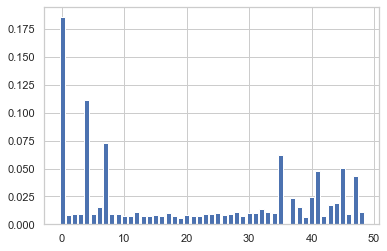

mcc for XGB_classifier  0.571758755431876
mcc for SVM_classifier  0.5673606232651268
Avg accuracy: 0.8861560937087354
 


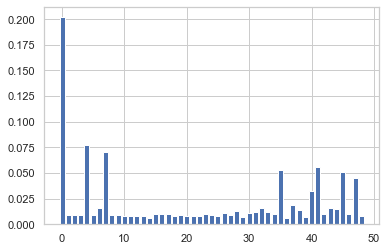

mcc for XGB_classifier  0.5953144007998066
mcc for SVM_classifier  0.5584954469587936
Avg accuracy: 0.8852935089576569
 


In [99]:
predic(X, y)

- Note the result is not good enough, since the data is imbalaned, it is reasonable to apply resampling

In [100]:
model_xgb_resampled = XGBClassifier(use_label_encoder = False,
                      eval_metric='mlogloss',
                      tree_method='gpu_hist')

model_svm_ovr_resampled = svm.SVC(decision_function_shape='ovr',
                        kernel='rbf',
                        gamma='auto')

In [101]:
def predic_resample(input_data, target_data):
    kf = KFold(n_splits = 5, shuffle=True)
    fold_data = []
    for train_index, test_index in kf.split(input_data, target_data):
        X_train, X_test = input_data.iloc[train_index], input_data.iloc[test_index]
        y_train, y_test = target_data.iloc[train_index], target_data.iloc[test_index]
        df_train = pd.merge(X_train, y_train, how = 'left', left_index = True, right_index = True)
        df_majority = df_train.loc[df_train['y'] == 0]
        df_minority = df_train.loc[df_train['y'] == 1]
        #Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=int(df_majority.shape[0]))

        df_up_down_sampled = pd.concat([df_majority, df_minority_upsampled])
        print(X_train.shape)
        X_train_resample = df_up_down_sampled[input_list]
        y_train_resample = df_up_down_sampled['y']

        scaler_X_train = preprocessing.StandardScaler().fit(X_train_resample)
        X_train_resample_scaled = scaler_X_train.transform(X_train_resample)

        scaler_X_test = preprocessing.StandardScaler().fit(X_test)
        X_test_scaled = scaler_X_test.transform(X_test)

        model_xgb_resampled.fit(X_train_resample, y_train_resample)
        model_svm_ovr_resampled.fit(X_train_resample_scaled, y_train_resample)
        y_pred_xgb = model_xgb_resampled.predict(X_test)
        y_pred_svm = model_svm_ovr.predict(X_test_scaled)
        print('mcc for XGB_classifier ', matthews_corrcoef(y_test, y_pred_xgb))
        print('mcc for SVM_classifier ', matthews_corrcoef(y_test, y_pred_svm))
        print(' ')

In [102]:
predic_resample(X, y)

(36168, 49)
mcc for XGB_classifier  0.5897652097554545
mcc for SVM_classifier  0.6198645945609634
 
(36169, 49)
mcc for XGB_classifier  0.5890866897652886
mcc for SVM_classifier  0.625259808735249
 
(36169, 49)
mcc for XGB_classifier  0.5937969554882063
mcc for SVM_classifier  0.6250378389920747
 
(36169, 49)
mcc for XGB_classifier  0.589780391162321
mcc for SVM_classifier  0.6130709837253616
 
(36169, 49)
mcc for XGB_classifier  0.5769908063423916
mcc for SVM_classifier  0.5996555351457565
 


# 5.Priciple Component Analysis

In [103]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [104]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [105]:
columns_name = df.columns.tolist()

In [106]:
i = 0
j = 0
list_i = []
for i in range(len(columns_name)):
    list_j = []
    for j in range(len(columns_name)):
        if df[columns_name[j]].dtypes == 'O' or df[columns_name[i]].dtypes == 'O':
            confusion_matrix = pd.crosstab(df[columns_name[i]], df[columns_name[j]])
            list_j.append(round(cramers_v(confusion_matrix.values), 3))
            j+=1
        else:
            confusion_matrix = df[columns_name[i]].corr(df[columns_name[j]])
            list_j.append(round(confusion_matrix, 3))
            j+=1
    list_i.append(list_j)
    i+=1

In [107]:
correlation_matrix = pd.DataFrame(list_i, columns=columns_name)

In [108]:
correlation_matrix.index = columns_name

In [109]:
correlation_matrix

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
year,1.000,-0.008,0.158,0.086,0.050,0.059,0.031,0.180,0.101,0.341,-0.170,0.523,0.037,-0.166,0.463,0.293,0.406,0.353
age,-0.008,1.000,0.240,0.347,0.150,0.000,0.098,0.240,0.073,0.179,-0.009,0.117,-0.005,0.005,-0.024,0.001,0.092,0.186
job,0.158,0.240,1.000,0.205,0.458,0.033,0.219,0.281,0.105,0.150,0.048,0.109,0.035,0.022,0.049,0.015,0.062,0.135
marital,0.086,0.347,0.205,1.000,0.121,0.018,0.196,0.020,0.052,0.045,0.049,0.071,0.047,0.035,0.045,0.024,0.028,0.066
education,0.050,0.150,0.458,0.121,1.000,0.014,0.227,0.119,0.080,0.123,0.053,0.109,0.010,0.028,0.051,0.022,0.035,0.072
default,0.059,0.000,0.033,0.018,0.014,0.999,0.297,0.003,0.077,0.023,0.018,0.057,0.000,0.019,0.000,0.036,0.040,0.022
balance,0.031,0.098,0.219,0.196,0.227,0.297,1.000,0.235,0.165,0.169,0.005,0.087,0.022,-0.015,0.003,0.017,0.000,0.249
housing,0.180,0.240,0.281,0.020,0.119,0.003,0.235,1.000,0.041,0.213,0.169,0.504,0.033,0.049,0.216,0.064,0.143,0.139
loan,0.101,0.073,0.105,0.052,0.080,0.077,0.165,0.041,1.000,0.015,0.061,0.182,0.015,0.005,0.046,0.037,0.055,0.068
contact,0.341,0.179,0.150,0.045,0.123,0.023,0.169,0.213,0.015,1.000,0.200,0.512,0.087,0.061,0.199,0.208,0.207,0.151


Text(0.5, 1.0, 'Correlation between different fearures')

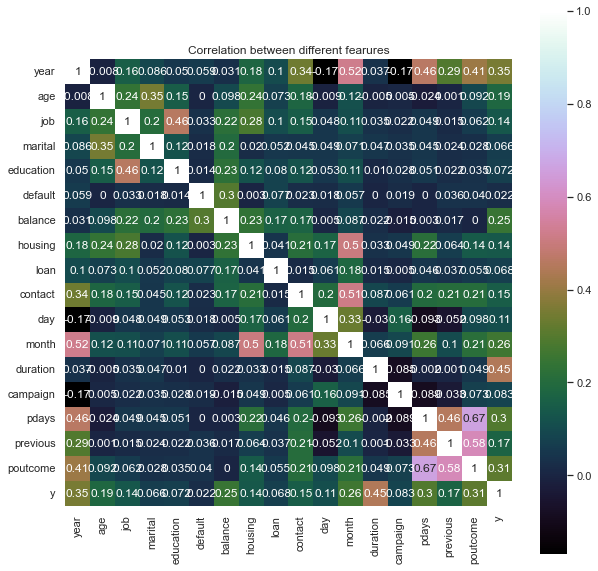

In [110]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlation between different fearures')


In [111]:
"""def predic_resample_pca(input_data, target_data):
    pca = prince.PCA(n_components = 5)
    kf = KFold(n_splits = 5, shuffle=True)
    fold_data = []
    for train_index, test_index in kf.split(input_data, target_data):
        X_train, X_test = input_data.iloc[train_index], input_data.iloc[test_index]
        y_train, y_test = target_data.iloc[train_index], target_data.iloc[test_index]
        df_train = pd.merge(X_train, y_train, how = 'left', left_index = True, right_index = True)
        df_majority = df_train.loc[df_train['y'] == 0]
        df_minority = df_train.loc[df_train['y'] == 1]
        #Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=int(df_majority.shape[0]))

        df_up_down_sampled = pd.concat([df_majority, df_minority_upsampled])
        print(X_train.shape)
        X_train_resample = df_up_down_sampled[input_list]
        y_train_resample = df_up_down_sampled['y']

        pca.fit(X_train_resample)

        scaler_X_train = preprocessing.StandardScaler().fit(X_train_resample)
        X_train_resample_scaled = scaler_X_train.transform(X_train_resample)

        scaler_X_test = preprocessing.StandardScaler().fit(X_test)
        X_test_scaled = scaler_X_test.transform(X_test)

        X_train_resample_pca = pca.transform(X_train_resample)
        X_train_resample_scaled_pca = pca.transform(X_train_resample_scaled)
        X_test_pca = pca.transform(X_test)
        X_test_scaled_pca = pca.transform(X_test_scaled)


        model_xgb_resampled.fit(X_train_resample_pca, y_train_resample)
        model_svm_ovr.fit(X_train_resample_scaled_pca, y_train_resample)
        y_pred_xgb = model_xgb_resampled.predict(X_test_pca)
        y_pred_svm = model_svm_ovr.predict(X_test_scaled_pca)
        print('mcc for XGB_classifier ', matthews_corrcoef(y_test, y_pred_xgb))
        print('mcc for SVM_classifier ', matthews_corrcoef(y_test, y_pred_svm))
        print(' ')
"""

"def predic_resample_pca(input_data, target_data):\n    pca = prince.PCA(n_components = 5)\n    kf = KFold(n_splits = 5, shuffle=True)\n    fold_data = []\n    for train_index, test_index in kf.split(input_data, target_data):\n        X_train, X_test = input_data.iloc[train_index], input_data.iloc[test_index]\n        y_train, y_test = target_data.iloc[train_index], target_data.iloc[test_index]\n        df_train = pd.merge(X_train, y_train, how = 'left', left_index = True, right_index = True)\n        df_majority = df_train.loc[df_train['y'] == 0]\n        df_minority = df_train.loc[df_train['y'] == 1]\n        #Upsample minority class\n        df_minority_upsampled = resample(df_minority,\n                                 replace=True,\n                                 n_samples=int(df_majority.shape[0]))\n\n        df_up_down_sampled = pd.concat([df_majority, df_minority_upsampled])\n        print(X_train.shape)\n        X_train_resample = df_up_down_sampled[input_list]\n        y_tr

In [112]:
"""predic_resample_pca(X,y)"""

'predic_resample_pca(X,y)'

In [113]:
input_list1 = df.columns.tolist()
famd  = prince.FAMD(n_components = 5)
famd.fit(df[input_list1])
print(famd.row_coordinates(df))


              0         1         2         3         4
0     -0.573903  0.656602 -0.718529  0.957704 -0.251044
1     -0.573276 -0.689745 -0.765183  0.963886 -0.266174
2     -0.704259 -0.943413 -0.611718  1.260364 -0.222817
3     -0.647486  0.001423 -0.643093  1.470506 -0.192606
4     -0.593988 -0.419838 -0.977961  0.453354 -0.587457
...         ...       ...       ...       ...       ...
45206  0.966547  1.329832 -1.241574 -1.711754  1.035286
45207  0.913813  2.917118 -0.640475 -0.204154  0.749283
45208  2.561056  3.299299 -0.672115 -1.065358  1.779081
45209  0.515531  1.361703 -0.141499 -0.080664  0.508822
45210  3.296490  0.127579  1.057206 -0.001956  0.248464

[45211 rows x 5 columns]
